In [1]:
from diffusers import UNet2DModel, DDIMScheduler
import torch
from diffusers.utils import randn_tensor
import torchvision
from PIL import Image
from io import BytesIO
import glob
import random
import os

In [2]:
class ImageAugment:
    def __init__(self, shrink_size=2, noise_level=1, down_sample_method=None):
        # noise_level (int): 0: no noise; 1: 75-95% quality; 2:50-75%
        if noise_level == 0:
            self.noise_level = [0, 0]
        elif noise_level == 1:
            self.noise_level = [5, 25]
        elif noise_level == 2:
            self.noise_level = [25, 50]
        else:
            raise KeyError("Noise level should be either 0, 1, 2")
        self.shrink_size = shrink_size
        self.down_sample_method = down_sample_method

    def shrink_img(self, hr_img):
        if self.down_sample_method is None:
            resample_method = random.choice(
                [Image.BILINEAR, Image.BICUBIC, Image.LANCZOS]
            )
        else:
            resample_method = self.down_sample_method
        img_w, img_h = tuple(map(lambda x: int(x / self.shrink_size), hr_img.size))
        lr_img = hr_img.resize((img_w, img_h), resample_method)
        return lr_img

    def add_jpeg_noise(self, hr_img):
        quality = 100 - round(random.uniform(*self.noise_level))
        lr_img = BytesIO()
        hr_img.save(lr_img, format="JPEG", quality=quality)
        lr_img.seek(0)
        lr_img = Image.open(lr_img)
        return lr_img

    def process(self, hr_patch_pil):
        w, h = hr_patch_pil.size
        lr_patch_pil = self.shrink_img(hr_patch_pil)
        if self.noise_level[1] > 0:
            lr_patch_pil = self.add_jpeg_noise(lr_patch_pil)
        lr_patch_pil = lr_patch_pil.resize((w, h), Image.BICUBIC)
        return lr_patch_pil, hr_patch_pil

    def up_sample(self, img, resample):
        width, height = img.size
        return img.resize(
            (self.shrink_size * width, self.shrink_size * height), resample=resample
        )


image_augment = ImageAugment(shrink_size=4, noise_level=1)

In [3]:
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from torch.utils.data import Dataset, DataLoader


class ImageData(Dataset):
    def __init__(
        self,
        img_folder,
        patch_size=256,
        shrink_size=4,
        noise_level=1,
        down_sample_method=None,
        color_mod="RGB",
        dummy_len=None,
    ):
        self.img_folder = img_folder
        all_img = glob.glob(self.img_folder + "/**", recursive=True)
        self.img = list(
            filter(
                lambda x: x.endswith("png") or x.endswith("jpg") or x.endswith("jpeg"),
                all_img,
            )
        )
        self.total_img = len(self.img)
        self.dummy_len = dummy_len if dummy_len is not None else self.total_img
        self.resize = transforms.Resize(patch_size)
        self.hflip = transforms.RandomHorizontalFlip()
        self.color_mod = color_mod
        self.img_augmenter = ImageAugment(shrink_size, noise_level, down_sample_method)

    def get_img_patches(self, img_file):
        img_pil = Image.open(img_file).convert("RGB")
        img_patch = self.resize(img_pil)
        # img_patch = self.hflip(img_patch)
        lr_hr_patches = self.img_augmenter.process(img_patch)
        return lr_hr_patches

    def __len__(self):
        return self.dummy_len  # len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        patch = self.get_img_patches(img)
        if self.color_mod == "RGB":
            lr_img = patch[0].convert("RGB")
            hr_img = patch[1].convert("RGB")
        elif self.color_mod == "YCbCr":
            lr_img, _, _ = patch[0].convert("YCbCr").split()
            hr_img, _, _ = patch[1].convert("YCbCr").split()
        else:
            raise KeyError("Either RGB or YCbCr")
        return to_tensor(lr_img), to_tensor(hr_img)


train_dataset = ImageData(
    "data/beans",
    patch_size=256,
    shrink_size=4,
    noise_level=1,
    down_sample_method=None,
    color_mod="RGB",
    dummy_len=None,
)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=20,
    shuffle=False,
    num_workers=8,
)

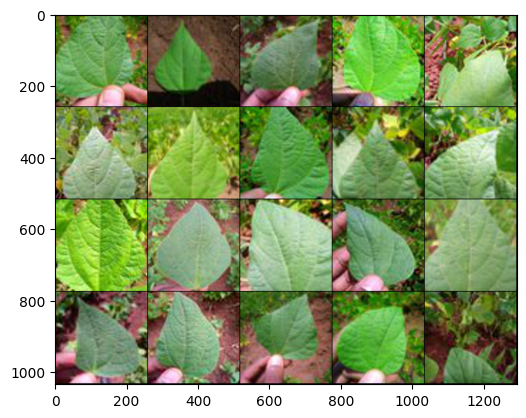

In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

plt.imshow(make_grid(next(iter(train_dataloader))[0], nrow=5).permute(1, 2, 0))

In [5]:
sr_unet = UNet2DModel.from_pretrained(
    "results/bean_sr_64to256/checkpoint-32000/unet_ema"
)
sr_unet.load_state_dict(torch.load("results/bean_sr_64to256/unet.pt"))
sr_unet = sr_unet.to(device="cuda")

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 32000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [6]:
noise_scheduler = DDIMScheduler(2000, 0.00085, 0.012, "scaled_linear")
num_inference_steps = 200
eta = 0.0
noise_scheduler.set_timesteps(num_inference_steps, device="cuda")
timesteps_tensor = noise_scheduler.timesteps

In [8]:
from tqdm import tqdm
import time

n = len(train_dataloader)
i = 1
weight_dtype = torch.float32
for lr_imgs, hr_imgs in train_dataloader:
    lr_imgs = lr_imgs.to(weight_dtype)
    lr_imgs = lr_imgs * 2 - 1
    lr_imgs = lr_imgs.to(device="cuda")

    b, c, h, w = lr_imgs.shape
    noisy_latents = randn_tensor(
        (b, 3, 256, 256),
        device="cuda",
        dtype=torch.float32,
    )

    time_counter = time.time()
    print(f"Starting processing batch {i}/{n}")
    with torch.no_grad():
        for t in tqdm(noise_scheduler.timesteps):
            model_output = sr_unet(
                torch.cat([noisy_latents, lr_imgs], dim=1),
                timestep=t.unsqueeze(0).to(lr_imgs.device),
            ).sample
            noisy_latents = noise_scheduler.step(
                model_output,
                t,
                noisy_latents,
            ).prev_sample
    sr_images = noisy_latents.cpu().detach().clamp(-1, 1)
    sr_images = (sr_images + 1) / 2

    # Save images
    os.makedirs(f"data/sr_64to256/sr_imgs", exist_ok=True)
    os.makedirs(f"data/sr_64to256/hr_imgs", exist_ok=True)
    for j in range(b):
        torchvision.utils.save_image(
            sr_images[j],
            f"data/sr_64to256/sr_imgs/{i}_{j}.png",
        )
        torchvision.utils.save_image(
            hr_imgs[j],
            f"data/sr_64to256/hr_imgs/{i}_{j}.png",
        )

    time_used = time.time() - time_counter
    time_uesed_by_h_m_s = time.strftime("%H:%M:%S", time.gmtime(time_used))
    print(f"Time used: {time_uesed_by_h_m_s}")

    i += 1

Starting processing batch 1/65


100%|██████████| 200/200 [00:46<00:00,  4.31it/s]


Time used: 00:00:46
Starting processing batch 2/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 3/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 4/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 5/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 6/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 7/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 8/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 9/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 10/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 11/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 12/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 13/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 14/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 15/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 16/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 17/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 18/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 19/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 20/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 21/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 22/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 23/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 24/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 25/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 26/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 27/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 28/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 29/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 30/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 31/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 32/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 33/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 34/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 35/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 36/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 37/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 38/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 39/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 40/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 41/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 42/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 43/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 44/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 45/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 46/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 47/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 48/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 49/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 50/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 51/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 52/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 53/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 54/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 55/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 56/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 57/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 58/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 59/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 60/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 61/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 62/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 63/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 64/65


100%|██████████| 200/200 [00:46<00:00,  4.30it/s]


Time used: 00:00:46
Starting processing batch 65/65


100%|██████████| 200/200 [00:27<00:00,  7.37it/s]


Time used: 00:00:27
